# Welcome

IMPORTS

In [2]:
import os
import sys
sys.path.append('../')

from collections import deque
from datetime import datetime

import cv2
import numpy as np
import tensorflow as tf
from IPython.core.display import display, Image

import experiment_runner.preprocess_data as preprocessor
import experiment_runner.models_config as models
import experiment_runner.datasets_config as datasets
import experiment_runner.feature_extractors_config as feature_extractors

C:\Users\Govin\AppData\Local\Temp\ipykernel_3924\797012056.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, Image


In [3]:
from absl import logging
logging.set_verbosity(logging.ERROR)

Setup constants

In [4]:
preprocessor.FEATURE_EXTRACTOR = feature_extractors.MovenetExtractor()
EXPERIMENT_NAME = 'example_UCF-3'

# Preprocess dataset

Set Hyperparameters

In [5]:
dataset_path = '../datasets/NTU-3'
extractor = preprocessor.FEATURE_EXTRACTOR

Preprocess features

In [7]:
preprocessor.prepare_all_videos(dataset_path, extractor)

Extracted features from video 0
Saved to  C:\Users\Govin\Desktop\BehaviouralMLProject\features\NTU-3\MovenetExtractor\ChestPain\S002C001P003R001A045_rgb.csv


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000021CB6D25D30>
Traceback (most recent call last):
  File "C:\Users\Govin\AppData\Local\Programs\Python\Python39\lib\weakref.py", line 371, in remove
KeyboardInterrupt: 


KeyboardInterrupt: 

# Train Models

## Set Model Hyper Parameters

EXPERIMENT PARAMETERS

In [8]:
EXPERIMENT_PARAMS = [
    {'name': 'lstm',
     'batch_size': 64,
     'epochs': 2,
     },
]

DATA PARAMETERS

In [15]:
DATASETS_PARAMS = [
    {'dataset_path': './datasets/UCF-3',
     'seq_len': 20,
     'train_test_split': .8
     },
]

EXTRACTOR PARAMETERS

In [16]:
EXTRACTOR_PARAMS = [
    (feature_extractors.MovenetExtractor, {}),
]

MODEL PARAMETERS

In [11]:
MODEL_PARAMS = [
    (models.LSTM.lstm2, {'activation_function': 'relu',
                       'loss_function': 'sparse_categorical_crossentropy',
                       'optimizer': 'adam',
                       }),
]

 ## Create train function

In [12]:
# TRAIN MODEL AND SAVE TO saved_experiments DIRECTORY
def train_model(model, dataset, experiment_params):
    experiment_dir = os.path.join(f'../saved_experiments/{EXPERIMENT_NAME}')

    log_dir = os.path.join(experiment_dir, 'logs/fit/',
                           experiment_params['name'] + '_' + datetime.now().strftime("%Y%m%d-%H%M%S"))

    save_model_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(experiment_dir, experiment_params['name']),
                                                             monitor='val_loss',
                                                             verbose=1,
                                                             save_best_only=True,
                                                             options=None,)

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=1,
                                                          update_freq='epoch',)

    model.fit(
        dataset.train_dataset,
        validation_data=dataset.validation_dataset,
        epochs=experiment_params['epochs'],
        batch_size=experiment_params['batch_size'],
        callbacks=[tensorboard_callback, save_model_callback],
    )
    print('==== EVAL ====')
    res = model.evaluate(
        dataset.test_dataset
    )

    # write eval results to tensorboard
    test_summary_writer = tf.summary.create_file_writer(os.path.join(log_dir, 'eval'))
    with test_summary_writer.as_default():
        tf.summary.scalar('test_loss', res[0], step=0)
        tf.summary.scalar('test_accuracy', res[1], step=0)

    return res

## Train Models

Launch tensorboard

In [13]:
from tensorboard import notebook
log_dir = os.path.join(f'../saved_experiments/{EXPERIMENT_NAME}/logs')
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Train loop

In [ ]:
# train test loop
for idx, (experiment_params, data_params, extractor_params, model_params) in \
        enumerate(zip(EXPERIMENT_PARAMS, DATASETS_PARAMS, EXTRACTOR_PARAMS, MODEL_PARAMS)):

    print(f'=== Training Model {experiment_params["name"]} ===')
    
    # init based on hyper parameters
    extractor = extractor_params[0](**extractor_params[1])  # get extractor
    dataset = datasets.Dataset.Training(**data_params, extractor=extractor)  # get data
    model = model_params[0](output_size=len(dataset.labels), **model_params[1])  # get model

    # train and save model
    train_model(model, dataset, experiment_params)  # train model
    
print('=== Training Done ===')

=== Training Model lstm ===
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\Govin\Desktop\BehaviouralMLProject\venv\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2838, in while_loop
    return result  File "C:\Users\Govin\Desktop\BehaviouralMLProject\venv\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2786, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "C:\Users\Govin\Desktop\BehaviouralMLProject\venv\lib\site-packages\tensorflow\python\ops\map_fn.py", line 493, in compute
    return (i + 1, tas)  File "C:\Users\Govin\Desktop\BehaviouralMLProject\venv\lib\site-packages\tensorflow\python\ops\map_fn.py", line 491, in <listcomp>
    ta.write(i, value) for (ta, value) in zip(tas, result_value_batchable)  File "C:\Users\Govin\D

INFO:tensorflow:Assets written to: ../saved_experiments/example_UCF-3\lstm\assets


289/289 [==============================] - 25s 67ms/step - loss: 0.8963 - sparse_categorical_accuracy: 0.5581 - val_loss: 0.5830 - val_sparse_categorical_accuracy: 0.6870
Epoch 2/2
279/289 [===========================>..] - ETA: 0s - loss: 0.4187 - sparse_categorical_accuracy: 0.7993WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 578 batches). You may need to use the repeat() function when building your dataset.



Epoch 2: val_loss improved from 0.58297 to 0.36815, saving model to ../saved_experiments/example_UCF-3\lstm
INFO:tensorflow:Assets written to: ../saved_experiments/example_UCF-3\lstm\assets


INFO:tensorflow:Assets written to: ../saved_experiments/example_UCF-3\lstm\assets


289/289 [==============================] - 16s 54ms/step - loss: 0.4187 - sparse_categorical_accuracy: 0.7993 - val_loss: 0.3681 - val_sparse_categorical_accuracy: 0.8756
==== EVAL ====
     34/Unknown - 1s 17ms/step - loss: 0.3618 - sparse_categorical_accuracy: 0.8410

# Run Models


Set Hyperparameters

In [14]:
SEQ_LEN = 20
MODEL_NAME = 'lstm'

Load Model

In [15]:
model_path = os.path.join('../saved_experiments', EXPERIMENT_NAME, MODEL_NAME)
model = tf.saved_model.load(model_path)

Run Model

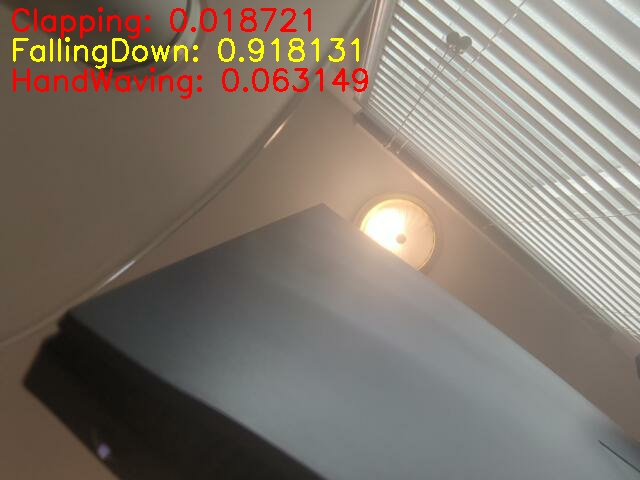

KeyboardInterrupt: 

In [17]:
frame_queue = deque(maxlen=SEQ_LEN)
cap = cv2.VideoCapture(0)
display_handle = display(None, display_id=True)
CLASS_LIST = list(os.walk(dataset_path))[0][1]

# video loop
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    height, width, channels = frame.shape

    # extract features and add to frame queue
    frame_features = preprocessor.FEATURE_EXTRACTOR.live_extract(frame)
    frame_queue.append(tf.keras.layers.Flatten()(frame_features))
    # load up frame queue
    if len(frame_queue)<SEQ_LEN:
        print('Queueing frame:', len(frame_queue), end='\r')
        continue
    x = tf.convert_to_tensor(list(frame_queue))
    x = tf.transpose(x, perm=[1, 0, 2])

    # make prediction
    if len(frame_queue) == SEQ_LEN:
        predicted_label_probabilities = model(x)[0]
        predicted_label = np.argmax(predicted_label_probabilities)
        predicted_class = CLASS_LIST[predicted_label]

    # write prediction to screen
    for idx, (pred, label) in enumerate(zip(predicted_label_probabilities.numpy(), CLASS_LIST)):
        cv2.putText(frame, label+': '+'{:f}'.format(pred) , (10, 30*(idx+1)), cv2.FONT_HERSHEY_SIMPLEX,1, (0, 255 if idx==predicted_label else 0, 255), 2)

    ret, frame = cv2.imencode('.jpeg', frame)
    display_handle.update(Image(data=frame.tobytes()))